# Sentiment Analysis using Support Vector Machine (SVM)

Import Package

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from google.colab import drive

In [ ]:
# Membaca data dari file Excel
df = pd.read_excel('/content/IKN Data (1).xlsx')

# Menampilkan beberapa baris pertama dari data
print(df.head())
df.drop_duplicates(inplace= True)
df.describe()

                                                text    label
0                    ikn ibukota koruptor nepotisme   negatif
1  sy mau tanya ikn itu untuk apa trs yg menempat...  negatif
2  bapak skolahin anak nya yg setinggi nnti bsa n...  negatif
3  wacana belim ada kesitu realnya dan faktanya a...  negatif
4  follow ig ikn pak udh dr lama kq buka lowongan...  negatif


,text,label
count,1471,1471
unique,1471,2
top,ikn ibukota koruptor nepotisme,negatif
freq,1,779


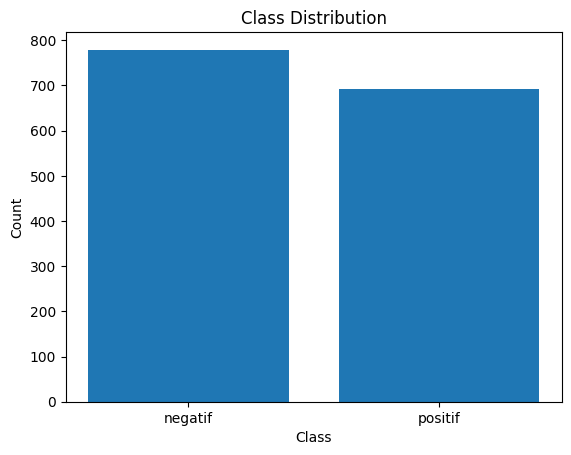

In [ ]:
import matplotlib.pyplot as plt

# Get class distribution from df
class_distribution = df['label'].value_counts()

# Prepare data
labels = class_distribution.index.to_list()
values = class_distribution.to_list()

# Plot the bar chart
plt.bar(labels, values)

# Add title and axis labels
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Show the plot
plt.show()


# SVM Model



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]


Best Parameters: {'C': 100, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'}
Accuracy: 0.8461538461538461
Classification Report:
              precision    recall  f1-score   support

     negatif       0.82      0.91      0.86       234
     positif       0.89      0.77      0.82       208

    accuracy                           0.85       442
   macro avg       0.85      0.84      0.84       442
weighted avg       0.85      0.85      0.84       442



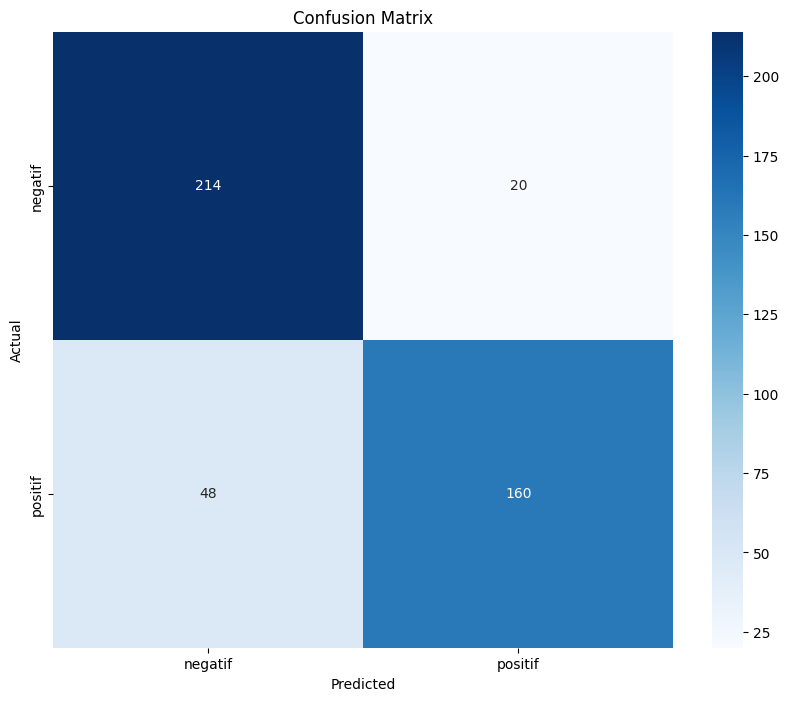

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Assuming df is your DataFrame containing 'text' and 'label' columns

# Preprocessing text
def preprocess_text(text):
    return text.lower()

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Use IndoBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
model = BertModel.from_pretrained('indobenchmark/indobert-base-p1')

# Function to get IndoBERT embedding
def get_indobert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Get embeddings for each text
X = df['text'].apply(lambda x: get_indobert_embedding(x))
X = np.vstack(X.values)
y = df['label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = [
    {'kernel': ['linear'], 'C': [0.1 ,1, 10, 100]},
    {'kernel': ['rbf'], 'C': [0.1 ,1, 10, 100], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5]},
    {'kernel': ['sigmoid'], 'C': [0.1 ,1, 10, 100], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5]},
]

# Perform grid search without cross-validation (cv=None)
grid_search = GridSearchCV(SVC(), param_grid, cv=None, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'\nBest Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Display Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get results from grid search
results = grid_search.cv_results_
# Print all metrics
print("Grid Search Results:")
for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print(f"Mean Accuracy: {mean_score:.4f} (±{std_score:.4f}) with: {params}")


Grid Search Results:
Mean Accuracy: 0.8154 (±0.0279) with: {'C': 0.1, 'kernel': 'linear'}
Mean Accuracy: 0.8076 (±0.0292) with: {'C': 1, 'kernel': 'linear'}
Mean Accuracy: 0.8076 (±0.0292) with: {'C': 10, 'kernel': 'linear'}
Mean Accuracy: 0.8076 (±0.0292) with: {'C': 100, 'kernel': 'linear'}
Mean Accuracy: 0.5987 (±0.0146) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Accuracy: 0.8046 (±0.0210) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Mean Accuracy: 0.5296 (±0.0010) with: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Mean Accuracy: 0.5296 (±0.0010) with: {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
Mean Accuracy: 0.8465 (±0.0249) with: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Accuracy: 0.8513 (±0.0241) with: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Mean Accuracy: 0.8231 (±0.0160) with: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Mean Accuracy: 0.5296 (±0.0010) with: {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
Mean Accuracy: 0.8542 (±0.0222) with: {'C': 10, 'gamma': 0

In [ ]:
print(f'\nBest Parameters: {grid_search.best_params_}')


Best Parameters: {'C': 100, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'}
